In [7]:
import os
import gc
import ot
import pickle
import anndata
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from anndata import AnnData, read_h5ad

import commot as ct

In [8]:
NX2_coor = pd.read_csv("coor_NX2.csv")
NX2_array = NX2_coor.values
NX2_array = np.delete(NX2_coor, 0, axis=1)

In [9]:
NX2_meta = pd.read_csv(
    "NX2_meta.csv",
).rename(columns={"Unnamed: 0": "cell"}).set_index('cell')
NX2_meta.index.name = None

In [10]:
NX2_counts = pd.read_csv("count_NX2.csv").rename(
    columns={"Unnamed: 0": "cell"}).set_index("cell")
NX2_counts.index.name = None

In [11]:
colnames = NX2_counts.columns.tolist()
var_name = pd.DataFrame(colnames, columns=['Gene']).set_index("Gene")
var_name.index.name = None

In [12]:
var_name

""
Igf2
Wnt3
Lhx2
Ccl11
Pdgfra
...
Cxcr2
Il5ra
Il6
Il7r


In [13]:
adata = AnnData(NX2_counts, obsm={"spatial": NX2_array},
                obs=NX2_meta, var=var_name)
adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)

In [14]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [35]:
df_cellchat = ct.pp.ligand_receptor_database(species='mouse', signaling_type='Secreted Signaling', database='CellChat')
print(df_cellchat.shape)

(1209, 4)


We then filter the LR pairs to keep only the pairs with both ligand and receptor expressed in at least 5% of the spots.

In [36]:
df_cellchat_filtered = ct.pp.filter_lr_database(df_cellchat, adata, min_cell_pct=0.05)
print(df_cellchat_filtered.shape)

(17, 4)


In [37]:
df_cellchat_filtered

,0,1,2,3
0,Wnt7a,Fzd1_Lrp5,WNT,Secreted Signaling
1,Wnt7a,Fzd2_Lrp5,WNT,Secreted Signaling
2,Wnt7a,Fzd5_Lrp5,WNT,Secreted Signaling
3,Wnt7a,Fzd8_Lrp5,WNT,Secreted Signaling
4,Wnt7a,Fzd1_Lrp6,WNT,Secreted Signaling
5,Wnt7a,Fzd2_Lrp6,WNT,Secreted Signaling
6,Wnt7a,Fzd5_Lrp6,WNT,Secreted Signaling
7,Wnt7a,Fzd8_Lrp6,WNT,Secreted Signaling
8,Tgfa,Egfr,EGF,Secreted Signaling
9,Fgf1,Fgfr1,FGF,Secreted Signaling


In [38]:
filtered_pathways = unique_values = df_cellchat_filtered.iloc[:, 2].unique()

Perform spatial communication inference for these 250 ligand-receptor pairs 

Now perform spatial communication inference for these ligand-receptor pairs with a spatial distance limit of 500. CellChat database considers heteromeric units. The signaling results are stored as spot-by-spot matrices in the obsp slots. For example, the score for spot i signaling to spot j through the LR pair can be retrieved from adata_dis500.obsp['commot-cellchat-Wnt4-Fzd4_Lrp6'][i,j]

In [39]:
ct.tl.spatial_communication(adata,
    database_name='cellchat', df_ligrec=df_cellchat_filtered, dis_thr=500, heteromeric=True, pathway_sum=True)

In [40]:
import plotly
import plotly.express as px

cluster_cmap = {}
celltypes = np.sort(list(set(adata.obs['CellType'])))
for i in range(len(celltypes)):
    cluster_cmap[celltypes[i]] = plotly.colors.qualitative.Alphabet[i]

WNT
EGF
FGF
PDGF
CSF
MK
GAS


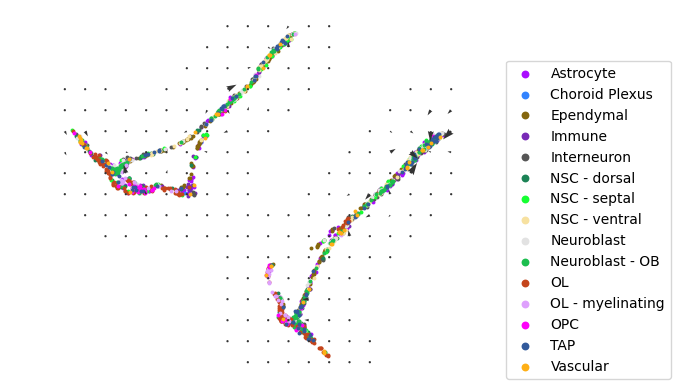

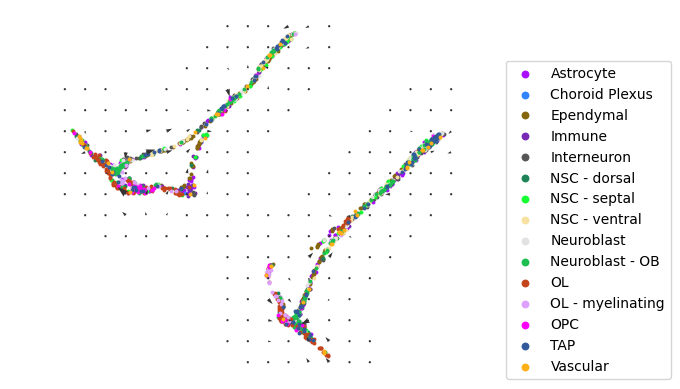

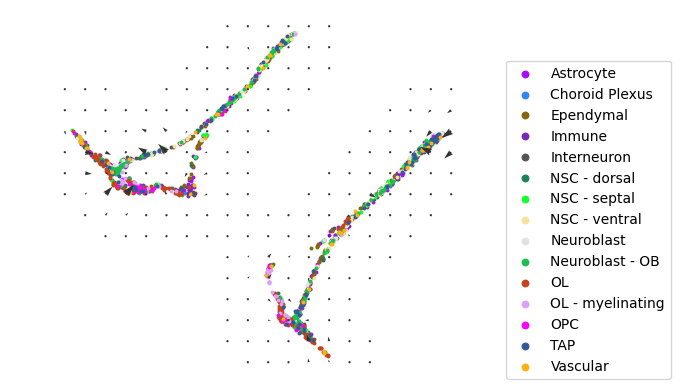

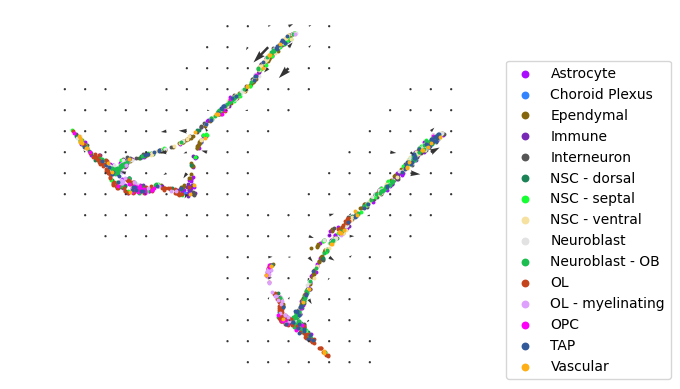

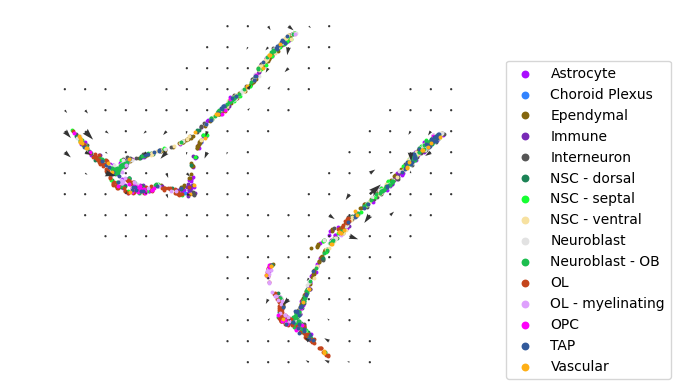

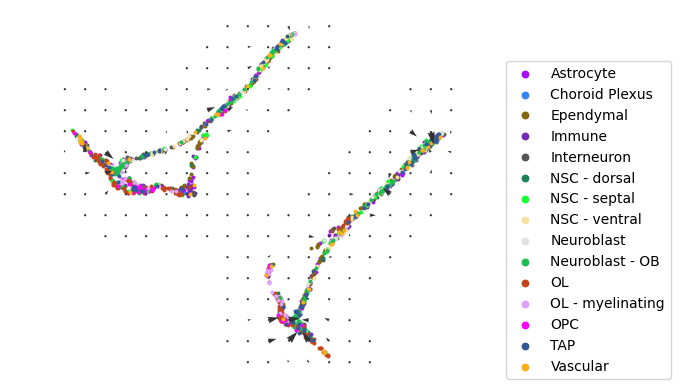

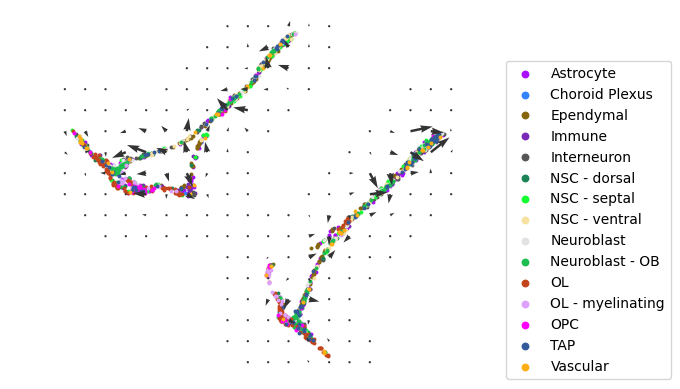

In [41]:
for pathway in filtered_pathways:
        print(pathway)
        ct.tl.communication_direction(adata, database_name='cellchat', pathway_name=pathway, k=200)
        ct.pl.plot_cell_communication(adata, database_name='cellchat', pathway_name=pathway, plot_method='grid', background_legend=True, 
            filename='./CCC_NX2/ccc_dir-%s.pdf' % (pathway), 
            scale=0.00006, ndsize=8, grid_density=0.4, summary='sender', background='cluster', clustering='CellType', cluster_cmap=cluster_cmap,
            normalize_v = True, normalize_v_quantile=0.995)

WNT
EGF
FGF
PDGF
CSF
MK
GAS


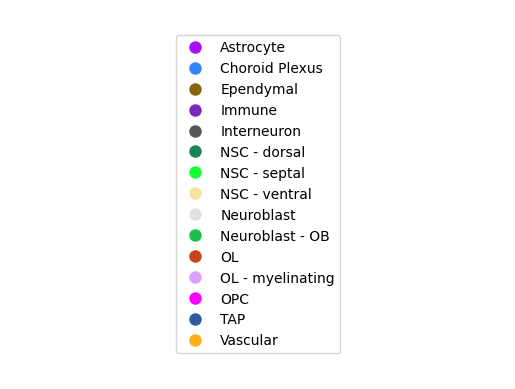

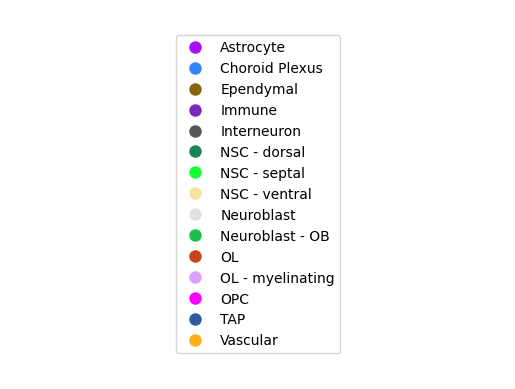

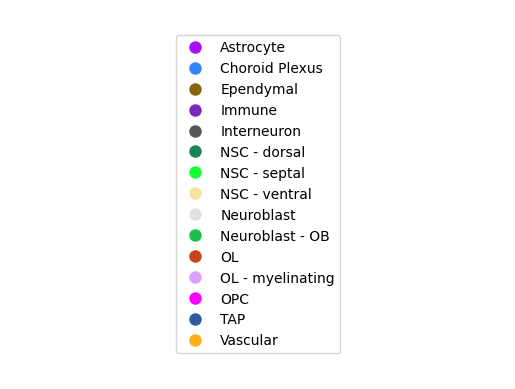

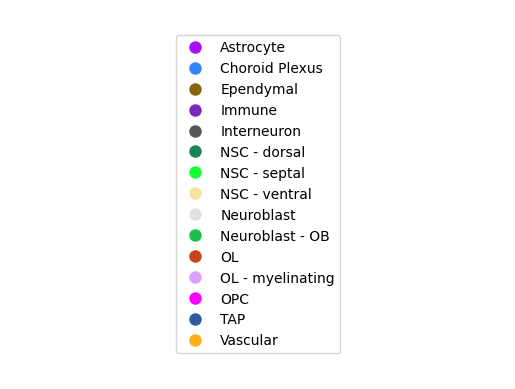

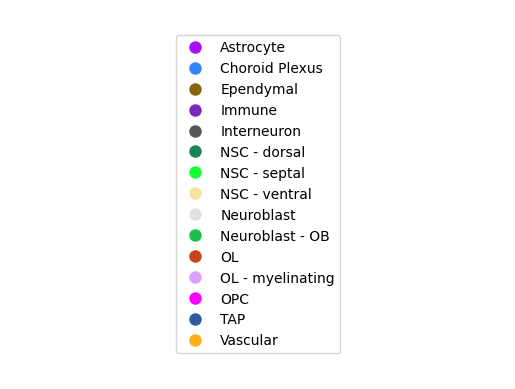

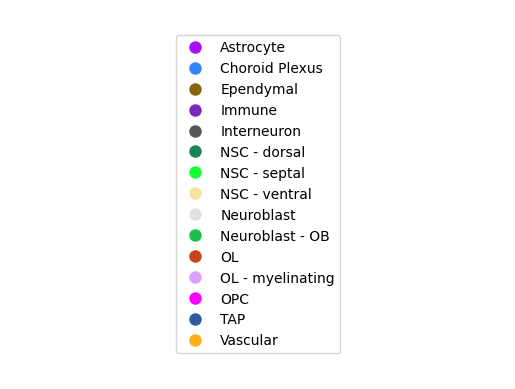

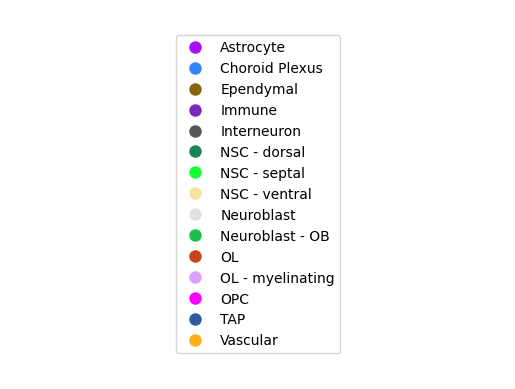

In [42]:
for pathway in filtered_pathways:
        print(pathway)
        ct.tl.cluster_communication(adata, database_name='cellchat', pathway_name=pathway, clustering='CellType', n_permutations=200)
        ct.pl.plot_cluster_communication_network(adata, uns_names=['commot_cluster-CellType-cellchat-%s' % pathway], clustering='CellType', p_value_cutoff=0.05, 
            nx_node_cmap='Alphabet', nx_node_pos=None, nx_bg_pos=False, filename='CCC_NX2/ccc_cluster-%s.pdf' % (pathway), nx_node_cluster_cmap=cluster_cmap)